# EDA

## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.io as so
from preprocess import rempy as rp
import seaborn as sns
from tqdm import tqdm

## Example of each sleep state

All EEG and EMG signals are recorded at 1000Hz. In this project, the signals are split into 2.5 second non-overlapping windows and labelled with one of 3 states: Wake, NREM, REM.

### Load recordings

In [2]:
# List of all recordings
ppath = '/workspace/Competition/SLEEP/EEG/data/raw/recordings'
recordings = os.listdir(ppath)

### Example with 1 recording

In [3]:
rec = recordings[0]

# Load raw EEG and EMG
EEG = np.squeeze(so.loadmat(os.path.join(ppath, rec, 'EEG.mat'))['EEG']).astype('float')
EMG = np.squeeze(so.loadmat(os.path.join(ppath, rec, 'EMG.mat'))['EMG']).astype('float')

# Load recording annotation
M,S = rp.load_stateidx(ppath, rec)

# Convert list of annotated states to list of tuples containing (state, duration, end_index)
Mvec = rp.nts(M)
Mtup = rp.vecToTup(Mvec, 0)

print(Mtup[0:5])


[('W', 185, 184), ('N', 5, 189), ('W', 2, 191), ('N', 4, 195), ('W', 2, 197)]


In [4]:
%matplotlib inline

(-1000.0, 1000.0)

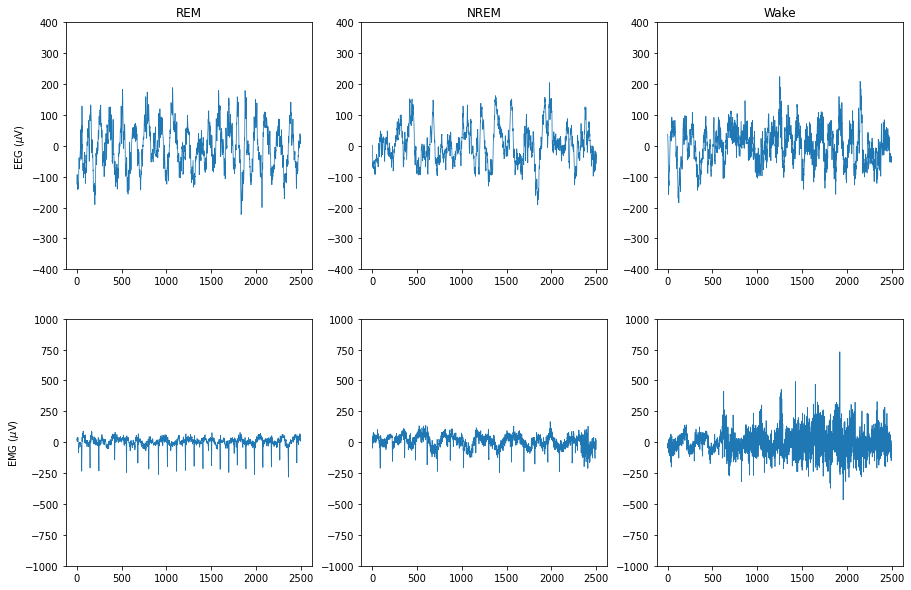

In [5]:
# Find instances of REM, NREM, and Wake that last at least 10 seconds
rem_idx = -1
nrem_idx = -1
wake_ids = -1

for x in Mtup:
    if (x[0]=='R')&(x[1]>=4):
        rem_idx = x[2]-x[1]+1
        break
for x in Mtup:
    if (x[0]=='N')&(x[1]>=4):
        nrem_idx = x[2]-x[1]+1
        break
for x in Mtup:
    if (x[0]=='W')&(x[1]>=4):
        wake_idx = x[2]-x[1]+1
        break

# corresponding indices of raw signal files
remstart_eegidx = (rem_idx)*2500 # we multiply 2500 for 2.5 seconds at 1000Hz
remend_eegidx = (rem_idx+1)*2500

nremstart_eegidx = (nrem_idx)*2500
nremend_eegidx = (nrem_idx+1)*2500

wakestart_eegidx = (wake_idx)*2500
wakeend_eegidx = (wake_idx+1)*2500

# Plot
xes = np.arange(0,2500)

plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.title('REM')
plt.plot(xes, EEG[remstart_eegidx:remend_eegidx], lw=0.75)
plt.ylabel('EEG ($\mu$V)')
plt.ylim([-400,400])
plt.subplot(2,3,2)
plt.title('NREM')
plt.plot(xes, EEG[nremstart_eegidx:nremend_eegidx], lw=0.75)
plt.ylim([-400,400])
plt.subplot(2,3,3)
plt.title('Wake')
plt.plot(xes, EEG[wakestart_eegidx:wakeend_eegidx], lw=0.75)
plt.ylim([-400,400])
plt.subplot(2,3,4)
plt.plot(xes, EMG[remstart_eegidx:remend_eegidx], lw=0.75)
plt.ylim([-1000,1000])
plt.ylabel('EMG ($\mu$V)')
plt.subplot(2,3,5)
plt.plot(xes, EMG[nremstart_eegidx:nremend_eegidx], lw=0.75)
plt.ylim([-1000,1000])
plt.subplot(2,3,6)
plt.plot(xes, EMG[wakestart_eegidx:wakeend_eegidx], lw=0.75)
plt.ylim([-1000,1000])

The 3 states exhibit distinct features in th EEG and EMG.
* REM - EEG wave oscillates within 5~9Hz range. Low EMG activity.
* NREM - EEG waves are slow (0.5~4.5Hz). Low EMG activity.
* Wake - EEG waves are fast and there is high EMG activity.

## EEG Spectral Density

The differences in EEG wave are clearer if we view the spectral density o the EEG. The Fourier transform takes a signal (the EEG wave) and transforms it from the time domain to the frequency domain.
Below, we go through our recordings and calculate the average spectral density during REM and NREM.

In [6]:
# Lists to store spectral density
remSpec = []
nremSpec = []

twin = 3

for rec in tqdm(recordings):
    # Find sampling rate, overlap, window size for FT
    sr = rp.get_sr(ppath, rec)
    nbin = int(np.round(sr)*2.5)
    dt = nbin * 1/sr
    nwin = np.round(twin*sr)
    EEG = np.squeeze(so.loadmat(os.path.join(ppath, rec, 'EEG.mat'))['EEG']).astype('float')
    # Load recording and process
    M,S = rp.load_stateidx(ppath, rec)
    Mvec = rp.nts(M)
    Mtup = rp.vecToTup(Mvec, 0)
    # Find nrem to rem transitions
    nrt_locs = rp.nrt_locations(Mtup)
    # Loop through all REM-NREM cycles
    cnt2 = 0
    while cnt2 < len(nrt_locs)-1:
        # One REM-NREM cycle
        sub = Mtup[nrt_locs[cnt2]:nrt_locs[cnt2+1]]
        # Find indices of each state
        states = np.array([x[0] for x in sub])
        remInds = np.where((states=='R'))[0]
        nremInds = np.where((states=='N'))[0]
        remSeqs = rp.stateSeq(sub, remInds)
        nremSeqs = rp.stateSeq(sub, nremInds)
        # Calculate spectral density
        subRemSp = []
        subNremSp = []
        subWakeSp = []
        for s in remSeqs:
            if len(s)*nbin>=nwin:
                b = int((s[-1]+1)*nbin)
                sup = list(range(int(s[0]*nbin), b))
                if sup[-1]>len(EEG):
                    sup = list(range(int(s[0]*nbin), len(EEG)))
                if len(sup) >= nwin:
                    Pow,F = rp.power_spectrum(EEG[sup], nwin, 1/sr)
                    subRemSp.append(Pow)
        for s in nremSeqs:
            if len(s)*nbin>=nwin:
                b = int((s[-1]+1)*nbin)
                sup = list(range(int(s[0]*nbin), b))
                if sup[-1]>len(EEG):
                    sup = list(range(int(s[0]*nbin), len(EEG)))
                if len(sup) >= nwin:
                    Pow,F = rp.power_spectrum(EEG[sup], nwin, 1/sr)
                    subNremSp.append(Pow)
        ifreq = np.where(F<=20) #Only inspect below 20 Hz
        sremSpec = np.array([x[ifreq] for x in subRemSp])
        snremSpec = np.array([x[ifreq] for x in subNremSp])
        #Calculate avg. spec. den. for given REM-NREM cycle
        if len(sremSpec)>0:
            avgRemSpec = np.mean(sremSpec, axis=0)
            remSpec.append(avgRemSpec)
        if len(snremSpec)>0:
            avgNremSpec = np.mean(snremSpec, axis=0)
            nremSpec.append(avgNremSpec)
        cnt2+=1 

100%|██████████| 6/6 [00:23<00:00,  3.99s/it]


Text(0, 0.5, 'Spectral Density ($\\mathrm{\\mu V^2/Hz}$)')

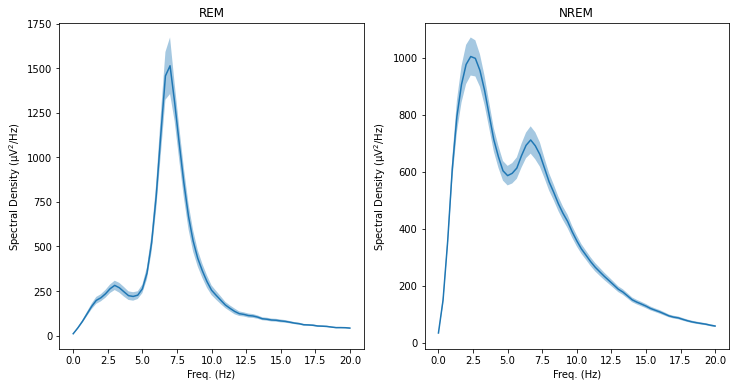

In [7]:
#Limit observation to frequencies in the range [0,20]Hz
ifreq = np.where(F<=20)
FN = F[ifreq]

remS = np.array(remSpec)
nremS = np.array(nremSpec)

#Confidence interval
aRemS = remS.mean(axis=0) - 2.576*remS.std(axis=0)/np.sqrt(len(remS))
bRemS = remS.mean(axis=0) + 2.576*remS.std(axis=0)/np.sqrt(len(remS))
aNremS = nremS.mean(axis=0) - 2.576*nremS.std(axis=0)/np.sqrt(len(nremS))
bNremS = nremS.mean(axis=0) + 2.576*nremS.std(axis=0)/np.sqrt(len(nremS))

#Plot
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('REM')
plt.plot(FN, remS.mean(axis=0))
plt.fill_between(FN, aRemS, bRemS, alpha=0.4)
plt.xlabel('Freq. (Hz)')
plt.ylabel('Spectral Density ($\mathrm{\mu V^2/Hz}$)')
plt.subplot(1,2,2)
plt.title('NREM')
plt.plot(FN, nremS.mean(axis=0))
plt.fill_between(FN, aNremS, bNremS, alpha=0.4)
plt.xlabel('Freq. (Hz)')
plt.ylabel('Spectral Density ($\mathrm{\mu V^2/Hz}$)')

As we can see from the two plots, it is clear that REM is characterized by oscillations in the theta (5-9.5 Hz) range whereas NREM is characterized by oscillations in the delta (0.5-4.5 Hz) range.

## Sleep state distribution

In [9]:
rem_durations = []
nrem_durations = []
wake_durations = []

for rec in tqdm(recordings):
    M,S = rp.load_stateidx(ppath, rec)
    Mvec = rp.nts(M)
    Mtup = rp.vecToTup(Mvec, 0)
    for x in Mtup:
        if x[0]=='R':
            rem_durations.append(x[1]*2.5)
        elif x[0]=='W':
            wake_durations.append(x[1]*2.5)
        else:
            nrem_durations.append(x[1]*2.5)

100%|██████████| 6/6 [00:00<00:00, 53.55it/s]


([<matplotlib.patches.Wedge at 0x7f88b80521f0>,
 [Text(1.0660511573578877, 0.2711732470136173, 'REM'),
  Text(-0.901913851008731, 0.629723276811808, 'NREM'),
  Text(0.7188384601835109, -0.8326291300218839, 'WAKE')],
 [Text(0.5814824494679387, 0.14791268018924578, '7.9%'),
  Text(-0.4919530096411259, 0.34348542371553153, '64.7%'),
  Text(0.3920937055546423, -0.4541613436483002, '27.3%')])

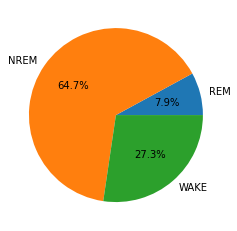

In [10]:
labels = ['REM', 'NREM', 'WAKE']
sizes = [sum(rem_durations), sum(nrem_durations), sum(wake_durations)]

plt.figure()
plt.pie(sizes, labels=labels, autopct='%1.1f%%')

In our datset, REM accounts for roughly 8%, NREM 65%, and Wake 27%. In general, it is known that REM sleep accounts for roughly 10%, NREM 60%, and Wake 30%.